# Processing data

In [208]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import cross_val_predict

In [209]:
url = r"..\data\raw\clean_house.csv"
house = pd.read_csv(url, sep=",")

## subsetting columns and rows

In [210]:
house.head(5)

,property_id,locality_name,postal_code,latitude,longitude,property_type,property_subtype,price,type_of_sale,number_of_rooms,...,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,swimming_pool,state_of_building,main_city,province
0,11157483,ronse,9600,50.741809,3.607601,HOUSE,HOUSE,245000.0,BUY_REGULAR,NaN,...,1.0,13.0,1.0,161.0,250.0,2.0,0.0,GOOD,ronse,oost-vlaanderen
1,11156843,merelbeke,9820,51.019250,3.760957,HOUSE,HOUSE,315000.0,BUY_REGULAR,NaN,...,1.0,23.0,NaN,NaN,77.0,2.0,NaN,GOOD,merelbeke,oost-vlaanderen
2,11161362,forêt,4870,50.563966,5.675489,HOUSE,HOUSE,325000.0,BUY_REGULAR,NaN,...,1.0,16.0,1.0,420.0,572.0,3.0,NaN,AS_NEW,trooz,luik
3,11153591,ottignies,1340,50.671784,4.575929,HOUSE,HOUSE,395000.0,BUY_REGULAR,NaN,...,1.0,37.0,1.0,76.0,165.0,2.0,NaN,GOOD,ottignies-louvain-la-neuve,waals-brabant
4,11128275,antwerpen merksem,2170,51.243743,4.443372,HOUSE,MIXED_USE_BUILDING,399900.0,BUY_REGULAR,NaN,...,NaN,NaN,NaN,NaN,65.0,2.0,0.0,GOOD,antwerpen,antwerpen


In [211]:
def replace_outliers(df, columns):
    for column in columns:
    # Outliers handling
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        max_value = Q3 + (1.5 * IQR)
        min_value = Q1 - (1.5 * IQR)

        outliers_mask = (df[column] < min_value) | (df[column] > max_value)
        df.loc[outliers_mask, column] = np.nan

        df.dropna(subset=[column], inplace=True)
    return df

In [212]:
lcolm = ["price"]
house = replace_outliers(house,lcolm)

In [213]:
house['postal_code'] = house['postal_code'].astype(str).str[:2]

## drop columns

In [214]:
def drop_columns(df, clist):
    ndf = df.drop(columns=clist)
    return ndf


In [215]:
todropcolumns = ["property_id", "locality_name", "latitude", "longitude", "property_type", "type_of_sale", "main_city"]
nhouse = drop_columns(house, todropcolumns)

In [216]:

# dropping the NaN values in the columns selected
def droping_null(df, colist):
    df.dropna(subset=colist, inplace=True)
    return df



## transform categorical data to numerical data

In [217]:
def transform_categorical2(df, clist):
    for column in clist:
        # One-hot encode the current column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_ohe = ohe.fit_transform(df[[column]])
        
        # Convert the one-hot encoded features to a DataFrame
        ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
        df = pd.concat([df, ohe_df], axis=1)
        
        # Drop the original categorical column
        df.drop(columns=[column], inplace=True)

    return df

In [218]:
def tranform_label_encoder(df, clist):
    for column in clist:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df



In [219]:
def select_best(df, clistColumns, predict, k):
    sk = SelectKBest(chi2, k=k)
    sk.fit(df[clistColumns], df[predict])
    selected_columns = df.columns[sk.get_support()]
    return df[selected_columns]

    

In [220]:
clist = ["state_of_building", "property_subtype"]
plist = ["province", "kitchen_type", "postal_code"]
chouse = transform_categorical2(nhouse, plist)
chouse = tranform_label_encoder(chouse, clist)
chouse = droping_null(chouse, "terrace")
chouse = droping_null(chouse, "garden")

## Make the training set and test set

In [221]:
def create_X_y(df, Y):
    X = df.drop(columns=[Y])
    y = df[[Y]]
    return X, y




In [222]:
X, y = create_X_y(chouse, "price")

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=20 )

## Imputation on the X_train, X_test

In [224]:
X_test.shape
X_train.shape 

(2428, 115)

In [225]:
X_train.head(5)

,property_subtype,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
3911,6,NaN,355.0,1.0,0.0,0.0,1.0,NaN,1.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3619,6,NaN,190.0,1.0,NaN,1.0,1.0,194.0,1.0,740.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5351,6,NaN,125.0,1.0,NaN,0.0,1.0,38.0,1.0,1722.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2698,6,NaN,210.0,1.0,0.0,0.0,1.0,NaN,1.0,1732.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1228,2,1.0,32.0,1.0,NaN,1.0,1.0,23.0,1.0,3800.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [226]:
def replace_NaN_Categorical(df, comlist):
    df[comlist] = df[comlist].fillna(0.0)
    

In [227]:
X_train = drop_columns(X_train, ["number_of_rooms", "furnished"])
X_test = drop_columns(X_test, ["number_of_rooms", "furnished"])

In [228]:
def change_to_int(df, columnsname):
    for column in columnsname:
        df[column] = df[column].round().astype(int)
    return df


In [229]:
def replace_null_median(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].median()
    return df

In [230]:
def replace_null_mean(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].mean()
    return df

In [231]:
def replace_null_to_zero(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = 0
    return df

### replacing values

In [232]:
X_train = replace_null_mean(X_train, ["terrace_area", "garden_area"])
X_train = replace_null_median(X_train, ["fully_equipped_kitchen", "number_of_facades"])
X_train = replace_null_to_zero(X_train, ["swimming_pool"])

X_test = replace_null_mean(X_test, ["terrace_area", "garden_area"])
X_test = replace_null_median(X_test, ["fully_equipped_kitchen", "number_of_facades"])
X_test = replace_null_to_zero(X_test, ["swimming_pool"])

In [233]:
X_train = change_to_int(X_train, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])
X_test = change_to_int(X_test, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

In [234]:
y_test = replace_null_mean(y_test, ["price"])
y_train = replace_null_mean(y_train, ["price"])

In [235]:
columns_with_null = X_train.columns[X_train.isnull().any()].tolist()
X_train = replace_null_to_zero(X_train, columns_with_null)
X_test = replace_null_to_zero(X_test, columns_with_null)

### scaling values

In [236]:
def scaling(df, cl):
    for column in cl:
        scaler = StandardScaler()
        #Fit and transform the data
        df[column] = scaler.fit_transform(df[[column]])
    return df

In [237]:
numerical_columns = ['living_area', 'terrace_area', 'garden_area', 'surface_of_good']
#X_test = scaling(X_test, numerical_columns)
#X_train = scaling(X_train, numerical_columns)

### testing the model

In [238]:
X_train.isnull().sum(), len(X_train)

(property_subtype          0
 living_area               0
 fully_equipped_kitchen    0
 open_fire                 0
 terrace                   0
                          ..
 postal_code_96            0
 postal_code_97            0
 postal_code_98            0
 postal_code_99            0
 postal_code_nan           0
 Length: 113, dtype: int64,
 2428)

In [239]:
y_test.isnull().sum()

price    0
dtype: int64

In [240]:
X_train.head()

,property_subtype,living_area,fully_equipped_kitchen,open_fire,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
3911,6,355.0,1,0.0,1.0,31.410128,1.0,80.0,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3619,6,190.0,1,1.0,1.0,194.000000,1.0,740.0,890.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5351,6,125.0,1,0.0,1.0,38.000000,1.0,1722.0,1722.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2698,6,210.0,1,0.0,1.0,31.410128,1.0,1732.0,2769.0,4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1228,2,32.0,1,1.0,1.0,23.000000,1.0,3800.0,3879.0,4,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [242]:
regressor.fit(X_train, y_train).predict(X_test)


array([[ 240233.1875 ],
       [ 430529.25   ],
       [ 368957.25   ],
       [ 364617.625  ],
       [ 428290.0625 ],
       [ 486305.46875],
       [ 448335.71875],
       [ 254913.625  ],
       [ 462470.03125],
       [ 367324.6875 ],
       [ 623135.4375 ],
       [ 345884.15625],
       [ 432394.3125 ],
       [ 234694.03125],
       [ 275130.     ],
       [ 502928.9375 ],
       [ 253238.8125 ],
       [ 502586.5625 ],
       [ 490485.25   ],
       [ 395007.25   ],
       [ 378107.125  ],
       [ 526647.5625 ],
       [ 271870.71875],
       [ 564292.46875],
       [ 333764.09375],
       [ 262210.71875],
       [ 337142.8125 ],
       [ 406500.     ],
       [ 339185.5625 ],
       [ 536559.03125],
       [ 614641.34375],
       [ 424838.625  ],
       [ 403029.5    ],
       [ 349208.9375 ],
       [ 467114.6875 ],
       [ 304213.78125],
       [ 411782.4375 ],
       [ 402952.71875],
       [ 866043.28125],
       [ 553417.1875 ],
       [ 447428.5625 ],
       [ 293093.

In [243]:
regressor.score(X_train, y_train)

0.4098257649979191

In [244]:
y_pred = regressor.predict(X_train)
score = r2_score(y_train, y_pred)
score

0.4098257649979191

In [245]:
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)
score

0.3316335428872672

## Cross validation

In [246]:
cv_pred = cross_val_predict(estimator=regressor, X=X_train, y=y_train, cv = 5)
#print("CV scores:", scores)
#print("mean score", scores.mean())
#print("std", scores.std())


In [247]:
print("Accuracy score:", r2_score(y_true=y_train, y_pred=cv_pred))

Accuracy score: -21409523.99554664


## Plotting the result

KeyError: 'postal_code'

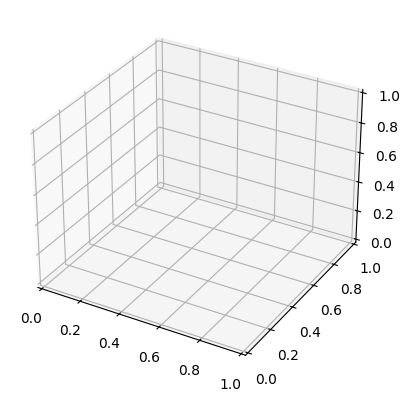

In [248]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train['price'], X_train['living_area'], X_train['postal_code'])